In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from z3 import *
import time
from qiskit import *

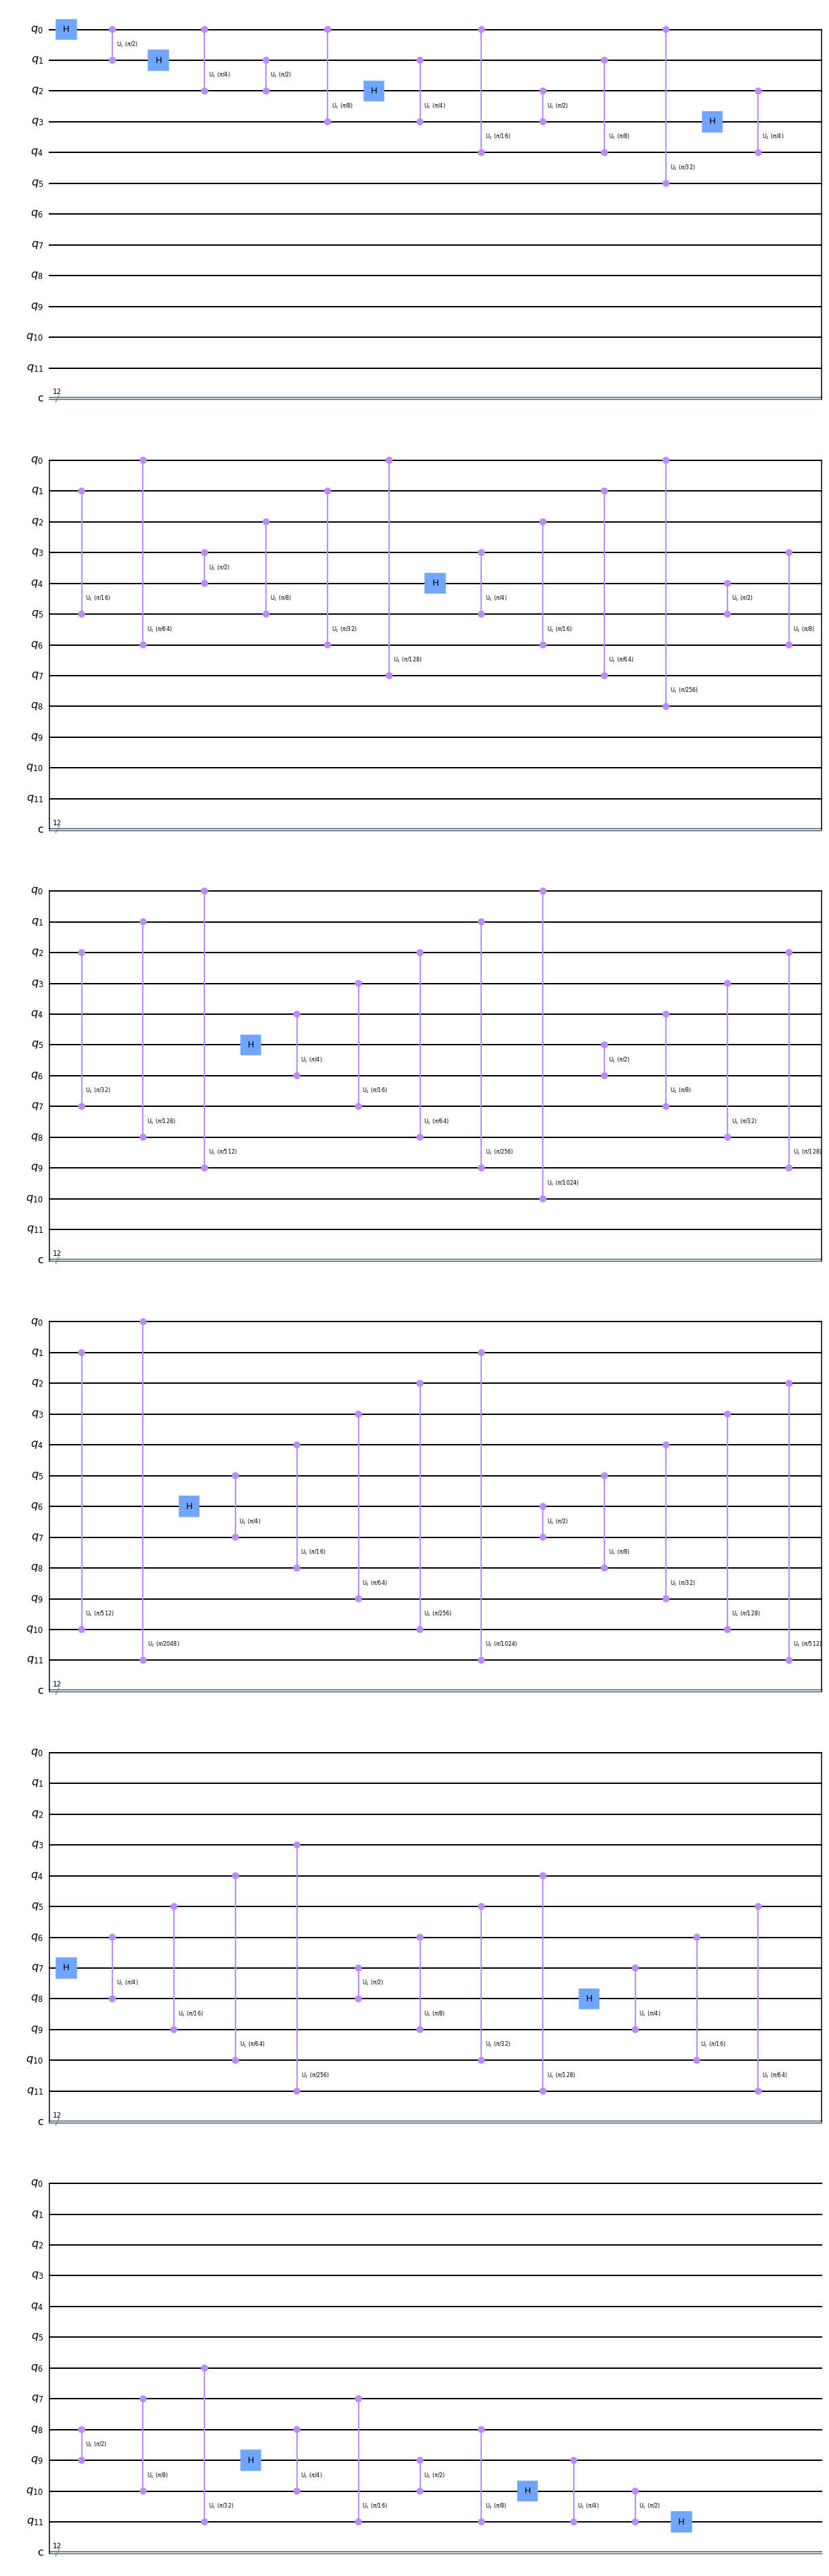

In [3]:
circ0 = QuantumCircuit().from_qasm_file('benchmark/qft_12.qasm')
circ0.draw('mpl')

In [5]:
from qiskit import Aer

backend = Aer.get_backend('unitary_simulator')
cvbe0_time_1 = time.time()
job = backend.run(circ0)
result = job.result()
cvbe0_time_2 = time.time()
print("C1 construction: %.6f"%(cvbe0_time_2-cvbe0_time_1))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Dachshund\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-a54dee7421b6>", line 5, in <module>
    job = backend.run(circ0)
  File "C:\Users\Dachshund\anaconda3\lib\site-packages\qiskit\utils\deprecation.py", line 27, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Dachshund\anaconda3\lib\site-packages\qiskit\providers\aer\backends\aerbackend.py", line 215, in run
    aer_job.submit()
  File "C:\Users\Dachshund\anaconda3\lib\site-packages\qiskit\providers\aer\jobs\aerjob.py", line 58, in submit
    self._future = self._executor.submit(self._fn, self._qobj, self._job_id)
  File "C:\Users\Dachshund\anaconda3\lib\concurrent\futures\thread.py", line 188, in submit
    self._adjust_thread_count()
  File "C:\Users\Dachshund\anaconda3\lib\concurrent\futures\thread.py", line 213, in _adjust_thread_

TypeError: object of type 'NoneType' has no len()

In [3]:
# backend = Aer.get_backend('unitary_simulator')
# job = backend.run(circ0)
# result = job.result()

# # Show the results
# # print(result.get_unitary(circ0, decimals=3))
# u = result.get_unitary(circ0, decimals=3).data
# cnt = 0
# for i in range(1024):
#     for j in range(1024):
#         if u[i][j] == 0.125+0.125j:
#             cnt += 1
# print(cnt)

In [4]:
# circ1 = QuantumCircuit().from_qasm_file('benchmark/RandomClifford_q5_0_1.qasm')
# circ1.draw('mpl')

In [5]:
def is_diagonal(U):
    i, j = np.nonzero(U)
    return np.all(i == j)

def add_hyper_index(var_list,hyper_index):
    for var in var_list:
        if not var in hyper_index:
            hyper_index[var]=0
            
def reshape(U):
    if U.shape==(2,2):
        return U
    
    if U.shape[0]==U.shape[1]:
        split_U=np.split(U,2,1)
    else:
        split_U=np.split(U,2,0)
    split_U[0]=reshape(split_U[0])
    split_U[1]=reshape(split_U[1]) 
    return np.array([split_U])[0]            
            
def get_real_qubit_num(cir):
    """Calculate the real number of qubits of a circuit"""
    gates=cir.data
    q=0
    for k in range(len(gates)):
        q=max(q,max([qbit.index for qbit in gates[k][1]]))
    return q+1

def get_total_qubit_num(cir):
    return cir.num_qubits

def cmp_term(x, y):
    if x.attr.real > y.attr.real:
        return 1
    elif x.attr.real == y.attr.real:
        if x.attr.imag > y.attr.imag:
            return 1
        elif x.attr.imag == y.attr.imag:
            return 0
        else:
            return -1
    else:
        return -1

def round_complex(x,n=6):
    a = round(x.real,n)
    b = round(x.imag,n)
    return a+b*(0.+1j)
    
def check_exp(exp):
    solver = Solver()
    solver.add(exp)
    if solver.check() == z3.sat:
        return True
    return False

In [6]:
class Term:
    def __init__(self, attr=0.+0.j, ref=None):
        self.attr = attr
        self.ref = ref
    def tensor(self, t1=None):
        attr1 = self.attr * t1.attr
        ref1 = And(self.ref, t1.ref)
        return Term(attr1, ref1)
    def exist(self, ex_var, boolref):
        exp_exist = Then('qe','simplify')(Exists([ex_var], boolref)).as_expr()
        exp_forall = Then('qe','simplify')(ForAll([ex_var], boolref)).as_expr()
        res = []
        solver = Solver()
        solver.add(exp_exist)
        if solver.check() == z3.sat:
            res.append(exp_exist)
        solver = Solver()
        solver.add(exp_forall)
        if solver.check() == z3.sat:
            res.append(exp_forall)
        return res
    def sequential(self, t1=None, ex_list=[]): # ex_list: vars
        attr1 = self.attr * t1.attr
        ref_0 = And(self.ref, t1.ref)
        res_refs = [ref_0]
        for ex_var in ex_list:
            new_res_refs = []
            for curr_ref in res_refs:
                new_res_refs += self.exist(ex_var, curr_ref)
            res_refs = new_res_refs
        res_terms = [Term(attr1, ref_i) for ref_i in res_refs] # Here simplify
        return res_terms
    def simplify(self):
        ref_new = simplify(self.ref)
        self.ref = ref_new
    def equalattr(self, t1=None):
        return self.attr == t1.attr
    def is_neg(self):
        solver = Solver()
        solver.add(self.ref)
        if solver.check() == z3.sat:
            return False
        return True
    def toCNF(self):
        self.ref = convert2cnf(self.ref)

In [7]:
def genRef(r, c, input_qubits, var_list, tt_input_num, q, curr_output):
    bias_in = curr_output
    bias_out = 2 if curr_output == 1 else 1
    input_vars = bin(r)[2:]
    if len(input_vars) < input_qubits:
        input_vars = '0'*(input_qubits-len(input_vars)) + input_vars
    output_vars = bin(c)[2:]
    if len(output_vars) < input_qubits:
        output_vars = '0'*(input_qubits-len(output_vars)) + output_vars
    reslist = []
    for i,e in enumerate(input_vars):
        if e == '1':
            reslist.append(var_list[q[i]+bias_in*tt_input_num])
        else:
            reslist.append(Not(var_list[q[i]+bias_in*tt_input_num]))
    for i,e in enumerate(output_vars):
        if e == '1':
            reslist.append(var_list[q[i]+bias_out*tt_input_num])
        else:
            reslist.append(Not(var_list[q[i]+bias_out*tt_input_num]))
    return And(tuple(reslist))

In [8]:
from functools import cmp_to_key

class CVBE:
    def __init__(self, termlist=[], mode=0): # Assume that terms are already regularized
        if mode == 0:
            self.term_list = self.deduplicate(termlist)
            self.regularized = 1
        else:
            self.term_list = termlist
            self.regularized = 0
    def deduplicate(self, termlist=[]):
        termdict = {}
        for term in termlist:
            if term.attr not in termdict:
                termdict[term.attr] = [term]
            else:
                termdict[term.attr].append(term)
        for attr in termdict:
            if len(termdict[attr]) > 1:
                term_rd = Term(attr, Or(tuple([t.ref for t in termdict[attr]])))
                termdict[attr] = term_rd
            else:
                termdict[attr] = termdict[attr][0]
        return list(termdict.values())
    def reduce(self):
        term_list_new = []
        for term in self.term_list:
            if not term.is_neg():
                term_list_new.append(term)
        self.term_list = term_list_new
    def simplify(self):
        for term in self.term_list:
            term.simplify()
    def regularize(self, termlist=[]):
        if termlist == []:
            termlist = self.term_list # len > 0
        ref_list = [term.ref for term in termlist]
        attr_list = [term.attr for term in termlist]
        term_num = len(termlist)
        ref_new_list, attr_new_list = [ref_list[0]], [attr_list[0]]
        for i in range(1, term_num): # curr_ref: ref_list[i]
            ref_new = ref_list[i]
            curr_term_num = len(ref_new_list)
            s1 = Solver()
            s1.add(ref_list[i])
            for j in range(curr_term_num):
                s1.add(Not(ref_new_list[j]))
                ref_new = And(ref_new, Not(ref_new_list[j]))
                if attr_list[i] + attr_new_list[j] != 0:
                    s2 = Solver()
                    s2.add(ref_list[i])
                    s2.add(ref_new_list[j])
                    if s2.check() == z3.sat:
                        ref_new_list.append(And(ref_list[i], ref_new_list[j]))
                        attr_new_list.append(attr_list[i]+attr_new_list[j])
                    else:
                        ref_new_list.append(ref_new_list[j])
                        attr_new_list.append(attr_new_list[j])
                        continue
                s2 = Solver()
                s2.add(Not(ref_list[i]))
                s2.add(ref_new_list[j])
                if s2.check() == z3.sat:
                    ref_new_list.append(And(Not(ref_list[i]), ref_new_list[j]))
                    attr_new_list.append(attr_new_list[j])
            if s1.check() == z3.sat:
                ref_new_list.append(ref_new)
                attr_new_list.append(attr_list[i])
            ref_new_list = ref_new_list[curr_term_num:]
            attr_new_list = attr_new_list[curr_term_num:]
            #
            term_temp_list = [Term(attr_new_list[i], ref_new_list[i]) for i in range(len(ref_new_list))]
            term_dedup_list = self.deduplicate(term_temp_list)
            ## Order!
            ref_new_list = [term.ref for term in term_dedup_list]
            attr_new_list = [term.attr for term in term_dedup_list]
        term_new_list = [Term(round_complex(attr_new_list[i]), ref_new_list[i]) for i in range(len(ref_new_list))] # not strong
        ### TERM MERGE!!!
        term_dedup_list = self.deduplicate(term_new_list)
        self.term_list = term_dedup_list
    def equals(self, c1, threshold=0.001):
        if len(self.term_list) != len(c1.term_list):
            print(len(self.term_list), len(c1.term_list))
            return False
        length = len(self.term_list)
        termlist0 = sorted(self.term_list, key=cmp_to_key(cmp_term))
        termlist1 = sorted(c1.term_list, key=cmp_to_key(cmp_term))
        print([term.attr for term in termlist0])
        print([term.attr for term in termlist1])
        res = True
        for i in range(len(termlist0)):
            attr_diff = termlist0[i].attr-termlist1[i].attr
            if abs(attr_diff.real) + abs(attr_diff.imag) >= threshold:
                print('attr_diff: ', attr_diff)
                res = False
            solver = Solver()
            solver.add(termlist0[i].ref!=termlist1[i].ref)
            if solver.check() == z3.sat:
                print(termlist0[i])
                print(termlist1[i])
                print(solver.model())
                res = False
            if res == False:
                return res
        return res
    def tensor(self, c1):
        termlist1 = []
        for term1 in self.term_list:
            for term2 in c1.term_list:
                termlist1.append(term1.tensor(term2))
        return CVBE(termlist1)
    def sequential(self, c1, ex_list=[]):
        termlist1 = []
        for term1 in self.term_list:
            for term2 in c1.term_list:
                termlist1 += (term1.sequential(term2, ex_list))
        c0 = CVBE(termlist1, 1)
#         c0.regularize()
        c0.simplify()
        return c0
    def toCNF(self):
        for i in range(len(self.term_list)):
            self.term_list[i].toCNF()

In [9]:
def convert2cnf(exp):
    s1 = Solver()
    s2 = Solver()
    s1.add(Not(exp))
    s2.add(Not(And(s1.assertions())))
    s2.set("core.minimize", True)

    clauses = []
    while sat == s1.check():
        mdl = s1.model()
        decls = mdl.decls()
        core = [d() for d in decls if is_true(mdl[d])] + [Not(d()) for d in decls if is_false(mdl[d])] 
        assert unsat == s2.check(core)
        clause = Or([mk_not(c) for c in s2.unsat_core()])
        clauses += [clause]
        s1.add(clause)
    return And(tuple(clauses))

In [10]:
def convert2cnf1(exp):
    return Tactic('tseitin-cnf')(exp).as_expr()

In [11]:
def print_cvbe(cvbe):
    for term in cvbe.term_list:
        print(term.attr, term.ref)

In [12]:
def init_cir(circ):
    qubits_num = get_total_qubit_num(circ)
    vars_num = qubits_num
    var_list = []
    for i in range(3*vars_num):
        var_list.append(Bool(str(i)))
    gates = circ.data
    gates_layer_list = [[]]
    head_ptr = [0]*qubits_num
    curr_head = 0
    for k in range(len(gates)):
        g = gates[k]
        q = [q.index for q in g[1]]
        if len(q) == 1:
            head_ptr[q[0]] += 1
        else:
            head_ptr[q[0]] = head_ptr[q[1]] = max(head_ptr[q[0]], head_ptr[q[1]]) + 1
        if head_ptr[q[0]] > curr_head:
            gates_layer_list.append([g])
            curr_head += 1
        else:
            gates_layer_list[head_ptr[q[0]]].append(g)
    return gates_layer_list,vars_num,var_list

In [13]:
def gen_cvbe_from_layer(gates_list, vars_num, var_list, curr_output):
    circ_cvbe = None
    uninvolved_q = [1]*vars_num
    bias_out = 2 if curr_output == 1 else 1
    for g in gates_list:
        nam = g[0].name
        q = [q.index for q in g[1]]
        if nam == 'cx': # ***
            tmp = q[0]
            q[0] = q[1]
            q[1] = tmp
        for idx in q:
            uninvolved_q[idx] = 0
        U = Operator(g[0]).data
        termlist = []
        for r in range(U.shape[0]):
            for c in range(U.shape[1]):
                if U[r][c] != 0:
                    ref = genRef(r,c,len(q), var_list, vars_num, q, curr_output)
                    termlist.append(Term(U[r][c], ref))
        cvbe = CVBE(termlist)
        if circ_cvbe == None:
            circ_cvbe = cvbe
        else:
            circ_cvbe = circ_cvbe.tensor(cvbe)
    identity_list = []
    for i in range(len(uninvolved_q)):
        if uninvolved_q[i] != 0:
            var_in = var_list[curr_output*vars_num+i]
            var_out = var_list[bias_out*vars_num+i]
            identity_list.append(var_in==var_out)
    if len(identity_list) != 0:
        identity_cvbe = CVBE([Term(1, And(tuple(identity_list)))])
        if circ_cvbe == None:
            circ_cvbe = identity_cvbe
        else:
            circ_cvbe = circ_cvbe.tensor(identity_cvbe)
    return circ_cvbe

In [14]:
std_layer = 1
def gen_cvbe(circ):
    gates_layer_list,vars_num,var_list = init_cir(circ)
    if len(gates_layer_list) % 2 != std_layer:
        gates_layer_list.append([])
    curr_output = 0
    circ_cvbe = None
    for ii,layer in enumerate(gates_layer_list[1:]):
        print(ii, 'layer')
        if ii != 0:
#             circ_cvbe.toCNF()
#             time_regularize1 = time.time()
            circ_cvbe.regularize()
            circ_cvbe.toCNF()
#             time_regularize2 = time.time()
#             print("time_regularize: ", time_regularize2 - time_regularize1)
#         time_layer1 = time.time()
        cvbe = gen_cvbe_from_layer(layer, vars_num, var_list, curr_output)
#         time_layer2 = time.time()
#         print("time_gen_from_layer: ", time_layer2 - time_layer1)
        cvbe.simplify()
        internal_vars = var_list[curr_output*vars_num:(curr_output+1)*vars_num]
        curr_output = 2 if curr_output == 1 else 1
        if circ_cvbe == None:
            circ_cvbe = cvbe
        else:
#             time_sequential1 = time.time()
            circ_cvbe = circ_cvbe.sequential(cvbe, internal_vars)
#             time_sequential2 = time.time()
#             print("time_sequential: ", time_sequential2 - time_sequential1)
#         time_cnf1 = time.time()
        circ_cvbe.toCNF()
#         time_cnf2 = time.time()
#         print("time_cnf: ", time_cnf2 - time_cnf1)
        print(len(circ_cvbe.term_list))
#     circ_cvbe.toCNF()
    return circ_cvbe

In [15]:
time1 = time.time()
cvbe0 = gen_cvbe(circ0)
cvbe0.regularize()
# cvbe0.toCNF()
time2 = time.time()
print('end cvbe0')
print(time2-time1)

<ipython-input-12-5f7879cb99b4>:13: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q = [q.index for q in g[1]]
<ipython-input-13-0eb654515598>:7: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q = [q.index for q in g[1]]


0 layer
2
1 layer
4
2 layer
4
3 layer
6
4 layer
8
5 layer
8
6 layer
4
7 layer
8
8 layer
4
9 layer
4
10 layer
8
11 layer
4
12 layer
4
13 layer
4
14 layer
12
15 layer
8
16 layer
8
17 layer
4
18 layer
4
19 layer
4
20 layer
4
21 layer
4
end cvbe0
237.77117896080017


In [16]:
# cvbe1 = gen_cvbe(circ1)
# cvbe1.regularize()
# cvbe1.toCNF()
# print('end cvbe1')

In [17]:
# cvbe0.equals(cvbe1)

In [18]:
type(cvbe0.term_list[0].ref)

z3.z3.BoolRef

In [19]:
import sys

In [20]:
sys.getsizeof(cvbe0.term_list[0].ref)

48

In [21]:
len(cvbe0.term_list[0].ref.children())

2

In [22]:
cvbe0.term_list[3].attr

(0.125+0.125j)

In [23]:
len(cvbe0.term_list)

4

In [24]:
def cnt_literals(exp):
    cnt = len(exp.children())
    if cnt == 1:
        return cnt
    for child in exp.children():
        cnt += cnt_literals(child)
    return cnt

In [25]:
cnt_literals(cvbe0.term_list[3].ref)

5106

In [26]:
# cvbe0.toCNF()